Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [1]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2021-01-25 10:23:43.547309


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d4562c18-3d01-4110-d707-48b82ba5de9d)
GPU 1: Tesla V100-SXM2-16GB (UUID: GPU-9c44e4aa-2342-c342-437b-2f435f4aa581)
GPU 2: Tesla V100-SXM2-16GB (UUID: GPU-5da48514-1b80-9761-08a6-1818f6a51f67)
GPU 3: Tesla V100-SXM2-16GB (UUID: GPU-81adc8d7-7c25-3e6b-e732-d72679baf578)


In [5]:
#%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.1974683670559898
GPU (s):
0.03214198804926127
GPU speedup over CPU: 6x


In [6]:
# from google.colab import drive
# drive.mount("/content/drive")
# print('done, mounted')

In [7]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [8]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:14.420640


In [9]:
cd ../

/mmfs1/data/aglinska/BC-MRI-AE


SHAPE THE DATA

In [10]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [11]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [12]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [13]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [14]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [15]:
# Get Scanner Types and Scanning Site
#df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2 = pd.read_csv('/mmfs1/data/aglinska/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

982/982


In [16]:
df['ScanSite'] = [val.split('/')[6] for val in df2['sub_path'].values]
df['ScannerType'] = [val.split('/')[8] for val in df2['sub_path'].values]

In [17]:
#Validate the array
v1 = np.array([ABIDE_data[i,:,:,:].sum() for i in range(ABIDE_data.shape[0])])
c = np.corrcoef(np.array([ABIDE_data[i,:,:,:].flatten() for i in range(ABIDE_data.shape[0])]))

In [18]:
# Progress Plotting Functions
def net_query():
    i = 0
    n = 50
    v_sl = s_encoder.predict(ABIDE_data[0:n,:,:,:])[i]#[0,:]
    v_bg = z_encoder.predict(ABIDE_data[0:n,:,:,:])[i]#[0,:]
    v = np.hstack((v_sl,v_bg))
    latent_vec = v;
    out = cvae_decoder.predict(latent_vec)

    im = out[:,:,:,:,0]
    im1 = ABIDE_data[0:n,:,:,:]
    ss = ((im-im1)**2).sum()

    return im[0,:,:,40],im1[0,:,:,40],ss

def net_plot(im,im1):
    plt.subplot(1,2,1);
    plt.imshow(im1);
    plt.subplot(1,2,2);
    plt.imshow(im);


%matplotlib inline
from IPython import display
import time
def plot_trainProgress(loss,im,im1):

    display.clear_output(wait=True);
    display.display(plt.gcf());
    #time.sleep(1.0)

    plt.figure(figsize=np.array((7,5)) );

    plt.subplot(2,2,1);
    plt.imshow(im1);plt.xticks([]);plt.yticks([]);
    plt.title('image')

    plt.subplot(2,2,3);
    plt.imshow(im);plt.xticks([]);plt.yticks([]);
    plt.title('reconstruction')

    # Last 1000
    plt.subplot(2,2,2);
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    ss = int(len(loss)*1/3)
    plt.plot(loss[ss::],alpha=.3)
    plt.plot(moving_average(loss[ss::], 100))
    
    # Last 100
    plt.subplot(2,2,4);
    n = 1000
    if len(loss)>n:
        plt.plot(loss[-n::]);plt.title(f'loss: last {n} iteration');
        plt.plot(moving_average(loss[-n::], 10))
    else:
        plt.plot(loss);plt.title('overall loss');

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.15, hspace=.45);

    plt.show();

# TRAIN THE VAE

In [19]:
train_vae = False

In [20]:
if train_vae:
  from scipy.spatial.distance import pdist
  from scipy.spatial.distance import squareform

  def plot_recon_vae():
      plt.figure(figsize=(5,5));
      plt.subplot(2,2,1)
      plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
      plt.subplot(2,2,2)
      plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

      plt.subplot(2,2,3)
      plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
      plt.subplot(2,2,4)
      plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [21]:
import pickle
if train_vae:
    latent_dim=32
    batch_size=64
    disentangle=False
    gamma=1
    
    encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
    loss = list()
    print('ready')
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan4th'
    fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/VAE_2D_b64_NoDis_g1'
    if os.path.exists(fn+'_loss.pickle'):
        print('loading weights')
        vae.load_weights(fn)
        loss = pickle.load(open(fn+'_loss.pickle','rb'))
    else:
        print('no weights found - initializing new')
        
    print(fn)

In [22]:
if train_vae:
    im1 = ABIDE_data[0:5,:,:,:][0,32,:,:];
    im = vae.predict(ABIDE_data[0:5,:,:,:])[0,32,:,:,0];
    plot_trainProgress(loss,im,im1);

In [23]:
if train_vae:
    batch_size = 64
    for i in tqdm(range(1,10000)):    
        history = vae.train_on_batch(ABIDE_data[np.random.randint(low=0,high=ABIDE_data.shape[0],size=batch_size),:,:,:]);
        loss.append(history);
        if np.mod(i,25)==0:
            im1 = ABIDE_data[0:5,:,:,:][0,32,:,:];
            im = vae.predict(ABIDE_data[0:5,:,:,:])[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,100)==0:
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)

# TRAIN THE CONTRASTIVE VAE

In [24]:
train_cvae = True

In [25]:
if train_cvae:
  import tensorflow as tf
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.special import expit
  from sklearn.metrics import silhouette_score
  from tensorflow.keras.layers import *
  from tensorflow.keras import backend as K
  from tensorflow.keras.models import Model
  from tensorflow.keras.losses import mse
  import os
  import pandas as pd
  from glob import glob
  #import helper


  def sampling(args):
      """Reparameterization trick by sampling fr an isotropic unit Gaussian.
      # Arguments:
          args (tensor): mean and log of variance of Q(z|X)
      # Returns:
          z (tensor): sampled latent vector
      """

      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      # by default, random_normal has mean=0 and std=1.0
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon


  def get_MRI_CVAE_3D(input_shape=(64,64,64,1), latent_dim=2, batch_size = 32, disentangle=False, gamma=1):
      #TODO: add discriminator loss, see if there is improvement. Perhaps try on shapes dataset if it's easier...

      image_size, _, _, channels = input_shape
      kernel_size = 3
      filters = 16
      intermediate_dim = 128
      epochs = 10
      nlayers = 2
      
      # VAE model = encoder + decoder
      # build encoder model
      inputs = Input(shape=input_shape, name='encoder_input')
      x = inputs
      for i in range(nlayers):
          filters *= 2
          x = Conv3D(filters=filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    padding='same')(x)

      # shape info needed to build decoder model
      shape = K.int_shape(x)

      # generate latent vector Q(z|X)
      x = Flatten()(x)
      x = Dense(intermediate_dim, activation='relu')(x)
      z_mean = Dense(latent_dim, name='z_mean')(x)
      z_log_var = Dense(latent_dim, name='z_log_var')(x)

      # use reparameterization trick to push the sampling out as input
      # note that "output_shape" isn't necessary with the TensorFlow backend
      z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

      # instantiate encoder model
      encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

      # build decoder model
      latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
      x = Dense(intermediate_dim, activation='relu')(latent_inputs)
      x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(x)
      x = Reshape((shape[1], shape[2], shape[3],shape[4]))(x)

      for i in range(nlayers):
          x = Conv3DTranspose(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              strides=2,
                              padding='same')(x)
          filters //= 2

      outputs = Conv3DTranspose(filters=1,
                                kernel_size=kernel_size,
                                activation='sigmoid',
                                padding='same',
                                name='decoder_output')(x)

      # instantiate decoder model
      decoder = Model(latent_inputs, outputs, name='decoder')

      #     decoder.summary()

      # instantiate VAE model
      outputs = decoder(encoder(inputs)[2])
      vae = Model(inputs, outputs, name='vae')

      if disentangle:
          discriminator = Dense(1, activation='sigmoid')

          z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
          z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
          s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
          s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)
          q_bar = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z2], axis=1),
              tf.keras.layers.concatenate([s2, z1], axis=1)],
              axis=0)
          q = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z1], axis=1),
              tf.keras.layers.concatenate([s2, z2], axis=1)],
              axis=0)
          q_bar_score = discriminator(q_bar)
          q_score = discriminator(q)        
          tc_loss = K.log(q_score / (1 - q_score)) 

          discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

      reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
      reconstruction_loss *= image_size * image_size


      kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      if disentangle:
          vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss) + gamma * K.mean(tc_loss) + K.mean(discriminator_loss)
      else:
          vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)

      vae.add_loss(vae_loss)
      vae.compile(optimizer='rmsprop')
      if disentangle:
          vae.metrics_tensors = [reconstruction_loss, kl_loss, tc_loss, discriminator_loss]
      #     vae.summary()
      return encoder, decoder, vae



  ####################################################################################################
  ####################################################################################################
  ####################################################################################################
  ####################################################################################################
  ####################################################################################################


  def get_MRI_CCVAE_3D(input_shape=(64,64,64,1), latent_dim=2, beta=1, disentangle=False, gamma=1, bias=True,batch_size = 64):
      
      image_size, _, _, channels = input_shape
      kernel_size = 3
      filters = 16
      intermediate_dim = 128
      epochs = 10
      nlayers = 2

      # build encoder model
      tg_inputs = Input(shape=input_shape, name='tg_inputs')
      bg_inputs = Input(shape=input_shape, name='bg_inputs')

      z_conv1 = Conv3D(filters=filters*2,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')
      
      z_conv2 = Conv3D(filters=filters*4,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')


      # generate latent vector Q(z|X)
      z_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias)
      z_mean_layer = Dense(latent_dim, name='z_mean', use_bias=bias)
      z_log_var_layer = Dense(latent_dim, name='z_log_var', use_bias=bias)
      z_layer = Lambda(sampling, output_shape=(latent_dim,), name='z')
      
      def z_encoder_func(inputs):
          z_h = inputs
          z_h = z_conv1(z_h)
          z_h = z_conv2(z_h)
          # shape info needed to build decoder model
          shape = K.int_shape(z_h)
          z_h = Flatten()(z_h)
          z_h = z_h_layer(z_h)
          z_mean =  z_mean_layer(z_h)
          z_log_var =  z_log_var_layer(z_h)
          z = z_layer([z_mean, z_log_var])
          return z_mean, z_log_var, z, shape

      tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)
      
      
      s_conv1 = Conv3D(filters=filters*2,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')
      
      s_conv2 = Conv3D(filters=filters*4,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                use_bias=bias,
                padding='same')


      # generate latent vector Q(z|X)
      s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias)
      s_mean_layer = Dense(latent_dim, name='s_mean', use_bias=bias)
      s_log_var_layer = Dense(latent_dim, name='s_log_var', use_bias=bias)
      s_layer = Lambda(sampling, output_shape=(latent_dim,), name='s')
      
      def s_encoder_func(inputs):
          s_h = inputs
          s_h = s_conv1(s_h)
          s_h = s_conv2(s_h)
          # shape info needed to build decoder model
          shape = K.int_shape(s_h)
          s_h = Flatten()(s_h)
          s_h = s_h_layer(s_h)
          s_mean =  s_mean_layer(s_h)
          s_log_var =  s_log_var_layer(s_h)
          s = s_layer([s_mean, s_log_var])
          return s_mean, s_log_var, s, shape

      tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
      bg_s_mean, bg_s_log_var, bg_s, _ = s_encoder_func(bg_inputs) 
      

      # instantiate encoder models
      z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
      s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')

  #    print("shape z")
  #    print(shape_z)
      
      # build decoder model
      latent_inputs = Input(shape=(2*latent_dim,), name='z_sampling')
      x = Dense(intermediate_dim, activation='relu', use_bias=bias)(latent_inputs)
      x = Dense(shape_z[1] * shape_z[2] * shape_z[3] * shape_z[4], activation='relu', use_bias=bias)(x)
      x = Reshape((shape_z[1], shape_z[2], shape_z[3],shape_z[4]))(x)
      
  #     x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias)(x)
  #     x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

      for i in range(nlayers):
          x = Conv3DTranspose(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              strides=2,
                              use_bias=bias,
                              padding='same')(x)
          filters //= 2

      outputs = Conv3DTranspose(filters=1,
                                kernel_size=kernel_size,
                                activation='sigmoid',
                                padding='same',
                                use_bias=bias,
                                name='decoder_output')(x)

      # instantiate decoder model
      cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

      def zeros_like(x):
          return tf.zeros_like(x)

      tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
      zeros = tf.keras.layers.Lambda(zeros_like)(tg_z)
      bg_outputs = cvae_decoder(tf.keras.layers.concatenate([zeros, bg_s], -1))
      fg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, zeros], -1))

      # instantiate VAE model
      cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs], 
                                  name='contrastive_vae')

      cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
                                      outputs=fg_outputs, 
                                      name='contrastive_vae_fg')
      
      if disentangle:
          discriminator = Dense(1, activation='sigmoid')
          
          z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z);print(tg_z)
          z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
          s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
          s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)
          
          q_bar = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z2], axis=1),
              tf.keras.layers.concatenate([s2, z1], axis=1)],
              axis=0)
        
          q = tf.keras.layers.concatenate(
              [tf.keras.layers.concatenate([s1, z1], axis=1),
              tf.keras.layers.concatenate([s2, z2], axis=1)],
              axis=0)
          
          q_bar_score = (discriminator(q_bar)+.1) *.85 # ULTIMATE MEGA HAXXX
          q_score = (discriminator(q)+.1) *.85 # ULTIMATE MEGA HAXXX
        
          tc_loss = K.log(q_score / (1 - q_score)) 
          
          discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
      else:
          tc_loss = 0
          discriminator_loss = 0
      
      
      reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs))
      reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs))
      reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3]


      kl_loss = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
      kl_loss += 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
      kl_loss += 1 + bg_s_log_var - tf.keras.backend.square(bg_s_mean) - tf.keras.backend.exp(bg_s_log_var)
      kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
      kl_loss *= -0.5

      cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma * tc_loss + discriminator_loss)
      cvae.add_loss(cvae_loss)
      cvae.compile(optimizer='rmsprop',run_eagerly=True)
      
      return cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder

In [26]:
def get_batch_idx(df,batch_size = 64):

    sub_scan_site = df['ScanSite'].values
    scanning_sites = np.unique(sub_scan_site)

    nsites = len(scanning_sites)

    this_site = np.random.randint(low=0,high=nsites)


    site_asd = (sub_scan_site==scanning_sites[this_site]) * (df['DxGroup'].values==1)
    site_td = (sub_scan_site==scanning_sites[this_site]) * (df['DxGroup'].values==2)

    asd_idx = np.nonzero(site_asd)[0]
    td_idx = np.nonzero(site_td)[0]

    while len(asd_idx) < batch_size: #if not enough copy over
        asd_idx = np.hstack((asd_idx,asd_idx))

    while len(td_idx) < batch_size: #if not enough copy over
        td_idx = np.hstack((td_idx,td_idx))

    assert len(np.unique(df.iloc[asd_idx]['Subject Type'].values)),'subject batch selection messed up'
    assert len(np.unique(df.iloc[asd_idx]['ScanSite'].values)),'subject batch selection messed up'
    assert len(np.unique(df.iloc[asd_idx]['ScannerType'].values)),'subject batch selection messed up'

    assert len(np.unique(df.iloc[td_idx]['Subject Type'].values)),'subject batch selection messed up'
    assert len(np.unique(df.iloc[td_idx]['ScanSite'].values)),'subject batch selection messed up'
    assert len(np.unique(df.iloc[td_idx]['ScannerType'].values)),'subject batch selection messed up'
    
    assert ~any([a in td_idx for a in asd_idx]),'you f***ed up'
    assert ~any([t in asd_idx for t in td_idx]),'you f***ed up'
    
    np.random.shuffle(asd_idx)
    np.random.shuffle(td_idx)

    asd_idx = asd_idx[0:batch_size]
    td_idx = td_idx[0:batch_size]

    return asd_idx,td_idx

In [27]:
# Make tqdm work for colab
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [28]:
import pickle

In [55]:
if train_cvae:
    latent_dim = 16
    #batch_size = 12
    batch_size = 64
    beta = 1;gamma = 1
    disentangle=True
    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    #fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Jan12_disentagled_l16'
    #fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/16dim_noDis_evBatch'
    fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/fake_abide_flipped_disentangled'
    
    #loss = pickle.load(open(fn+'_loss.pickle','rb'))
    #cvae.load_weights(fn)

Tensor("z/add_6:0", shape=(None, 16), dtype=float32)


In [56]:
fn

'/mmfs1/data/aglinska/tf_outputs/CVAE/fake_abide_flipped_disentangled'

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

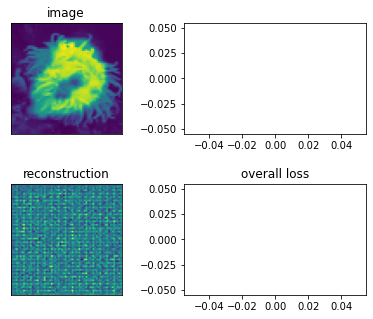

In [57]:
# Initial Check
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = net_query();
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = net_query();
    plot_trainProgress(loss,im,im1);

In [58]:
def plot_four():
    
    im_in = [DX_batch,TD_batch][np.random.choice([0,1])]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))
    im_out = cvae_decoder(cvae_full_vec)

    plt.figure(figsize=(5,5))
    s = 11
    plt.subplot(2,2,1)
    plt.imshow(im_in[s,:,:,0]);plt.xticks([]);plt.yticks([]);plt.title('input')

    plt.subplot(2,2,2)
    plt.imshow(cvae_decoder(cvae_full_vec)[s,:,:,0,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction')

    plt.subplot(2,2,3)
    plt.imshow(cvae_decoder(cvae_sal_vec)[s,:,:,0,0]);plt.xticks([]);plt.yticks([]);plt.title('salient')

    plt.subplot(2,2,4)
    plt.imshow(cvae_decoder(cvae_bg_vec)[s,:,:,0,0]);plt.xticks([]);plt.yticks([]);plt.title('background')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

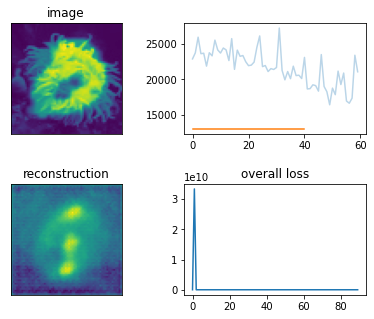

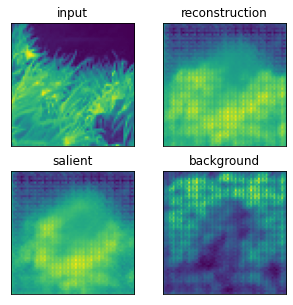

  0%|          | 90/999999 [01:29<324:13:50,  1.17s/it]

In [ ]:
for i in tqdm(range(1,int(1e6))):
    
    #asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
    #DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
    #TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)
    DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
    TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
    #hist = cvae.train_on_batch([DX_batch,TD_batch]); # Proper 
    hist = cvae.train_on_batch([TD_batch,DX_batch]); # Flipped
    
    assert not np.isnan(hist),'loss is NaN - you f**cked up'
    
    im,im1,ss = net_query();
    
    loss.append(hist);
    
    if np.mod(i,10)==0:
        plot_trainProgress(loss,im,im1);
        pickle.dump(loss,open(fn+'_loss.pickle','wb'))
        plot_four()
        
  
        
    if np.mod(i,101)==0:
        cvae.save_weights(fn)

In [ ]:
# s = 2
# plt.subplot(1,3,1)
# plt.imshow(TD_batch[s,:,:,0]);plt.xticks([]);plt.yticks([])
# plt.subplot(1,3,2)
# plt.imshow(cvae.predict([DX_batch,TD_batch])[0][s,:,:,0,0]);plt.xticks([]);plt.yticks([])
# plt.subplot(1,3,3)
# plt.imshow(cvae.predict([DX_batch,TD_batch])[1][s,:,:,0,0]);plt.xticks([]);plt.yticks([])